In [1]:
#pip install PySoundFile
#pip install librosa
#pip install mutagen

### Imports

In [17]:
import scipy
import numpy as np
import librosa.display
from IPython.display import Audio, display
import matplotlib.pyplot as plt
import os
import json
import time
import pprint                       # Used for prettier printing
from mutagen.easyid3 import EasyID3 # Used for mp3 metadata

### Ignore warnings, librosa.load of mp3 produces warnings

In [2]:
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

### Constants

In [5]:
hop_length = 512
bass_threshold = 0.3
bass_n_lower_bins = 5

# Mel spectrogram bins, from librosa.core.mel_frequencies()
low_eq = (0, 9)    # 20 & 200 Hz
mid_eq = (9, 99)   # 200 to 5,000 Hz
high_eq = (99, 128) # 5,000 to 20,000 Hz

### Helper funcs

In [33]:
def get_frequencys_vector(spectrogram, beats, threshold, start, end):    
    frequency = np.mean(spectrogram[start:end], axis=0)
    frequency_per_beat = []

    prev = 0
    for beat in beats:
        frequency_per_beat.append(np.average(frequency[prev:beat]))
        prev = beat

    max_frequencis_for_bar = np.max(frequency_per_beat)
    return [1 if i / max_frequencis_for_bar > threshold else 0 for i in frequency_per_beat]

def get_bass_level_change(bass_vec, beat_times, beat_change_lim):
    indexes_to_add = [0] # Add first beat
    prev_i = 0
    current_range = []
    
    for i in range(1, len(bass_vec)): 
        if bass_vec[i-1] != bass_vec[i]:
            if i - prev_i < beat_change_lim:
                current_range.append(i)
            else:
                if len(current_range) > 2:
                    for j in current_range[1:-1]:
                        indexes_to_add.remove(j-1)
                current_range = [i]
            # Dond add first beat twice
            if i-1 != 0:
                indexes_to_add.append(i-1)
            
            prev_i = i
    
    if len(current_range) > 2:
        for j in current_range[1:-1]:
            indexes_to_add.remove(j-1)
    bass_level_change = [beat_times[i] for i in indexes_to_add]
    bass_level_change.append(beat_times[-1])
    return bass_level_change

def get_song_metadata(song_path):
    # Load in the song
    y, sr = librosa.load(path=song_path)
    # get song sections
    onset_env = librosa.onset.onset_strength(y=y, sr=sr, aggregate=np.median)
    times = librosa.times_like(onset_env, sr=sr, hop_length=hop_length)
    M = librosa.feature.melspectrogram(y=y, sr=sr, hop_length=hop_length)
    tempo, beats = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)
    bass_vec = get_frequencys_vector(M, beats, bass_threshold, 0, bass_n_lower_bins)
    bass_level_change = get_bass_level_change(bass_vec, beats, 8)
    # Generate metadata
    audio = EasyID3(song_path)
    file_name = song_path.split('/')[-1]
    
    song_sections = []

    for i in range(1, len(times[bass_level_change])):
        start, end = times[bass_level_change][i-1], times[bass_level_change][i]
        start_sample, end_sample = int(start * sr), int(end * sr)
        y_section = y[start_sample: end_sample]
        # BPM calculation
        section_onset_env = librosa.onset.onset_strength(y=y_section, sr=sr, aggregate=np.median)
        section_tempo, section_beats = librosa.beat.beat_track(onset_envelope=section_onset_env, sr=sr)
        # Chroma
        section_chroma = np.average(librosa.feature.chroma_cqt(y=y_section, sr=sr, hop_length=hop_length), axis=1).tolist()
        # Calculate mel spectrogram
        section_M = librosa.feature.melspectrogram(y=y_section, sr=sr, hop_length=hop_length)
        # Bass level
        section_bass = np.mean(section_M[low_eq[0]: low_eq[1]])
        # Mids level
        section_mids = np.mean(section_M[mid_eq[0]: mid_eq[1]])
        # Highs level
        section_highs = np.mean(section_M[high_eq[0]: high_eq[1]])
        # Create dict of metadata
        song_sections.append({
            "start": float(start), 
            "end": float(end), 
            "bpm": float(section_tempo),
            "section_chroma": section_chroma,
            "section_bass": float(section_bass),
            "section_mids": float(section_mids),
            "section_highs": float(section_highs)
        })

        #display(Audio(data=y_section, rate=sr))

    beat_present = song_sections[0]["section_bass"] > song_sections[1]["section_bass"]
    for song_section in song_sections:
        song_section["beat_present"] = beat_present
        beat_present = not beat_present

    song_meta = {
        "file_name": file_name,
        "title": audio["title"][0],
        "artist": audio["artist"][0],
        "album": audio["album"][0],
        "general_bpm": tempo,
        "section_count" : len(song_sections),
        "song_sections" : song_sections
    }
    
    return song_meta

In [34]:
music_dir = "Music"
metadata_dir = "metadata"
song_paths = [f"{music_dir}/{i}" for i in os.listdir(music_dir) if i.split(".")[-1] == "mp3"]

for song_path in song_paths:
    file_name = song_path.split('/')[-1].replace(".mp3", "")
    print(f"Genetating metadata for: {file_name}")
    start_t = time.time()
    metadata = get_song_metadata(song_path)
    end_t = time.time()
    print(f"Metadata genetation for {file_name} took {round(end_t - start_t)} seconds")
    
    with open(f"{metadata_dir}/{file_name}.json", 'w', encoding="utf8") as f:
        json.dump(metadata, f)
        
print("Metadata generated")

Genetating metadata for: Jody Wisternoff - Paramour (Original Mix)
Metadata genetation for Jody Wisternoff - Paramour (Original Mix) took 85 seconds
Genetating metadata for: Kedr Livanskiy - Sky Kisses (на танцполе)
Metadata genetation for Kedr Livanskiy - Sky Kisses (на танцполе) took 66 seconds
Genetating metadata for: Nublu - öölaps!
Metadata genetation for Nublu - öölaps! took 61 seconds
Genetating metadata for: Otha - Tired and Sick
Metadata genetation for Otha - Tired and Sick took 87 seconds
Genetating metadata for: Smash Mouth - All Star
Metadata genetation for Smash Mouth - All Star took 75 seconds
Genetating metadata for: Terminaator - Kuutõbine
Metadata genetation for Terminaator - Kuutõbine took 106 seconds
Metadata generated


### Visualize the song

In [10]:
#song_path = "Music/Jody Wisternoff - Paramour (Original Mix).mp3"
#song_path = "Music/Otha - Tired and Sick.mp3"
#song_path = "Music/Kedr Livanskiy - Sky Kisses (на танцполе).mp3"
song_path = "Music/Nublu - öölaps!.mp3"
#song_path = "Music/Smash Mouth - All Star.mp3"
#song_path = "Music/Terminaator - Kuutõbine.mp3"


y, sr = librosa.load(path=song_path) #, offset=45, duration=10

onset_env = librosa.onset.onset_strength(y=y, sr=sr, aggregate=np.median)
times = librosa.times_like(onset_env, sr=sr, hop_length=hop_length)

M = librosa.feature.melspectrogram(y=y, sr=sr, hop_length=hop_length)
onset_env = librosa.onset.onset_strength(y=y, sr=sr, aggregate=np.median)
tempo, beats = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)
chroma = librosa.feature.chroma_cqt(y=y, sr=sr, hop_length=hop_length)
bass_vec = get_frequencys_vector(M, beats, bass_threshold, 0, bass_n_lower_bins)
bass_level_change = get_bass_level_change(bass_vec, beats, 8)
file_name = song_path.split('/')[-1]

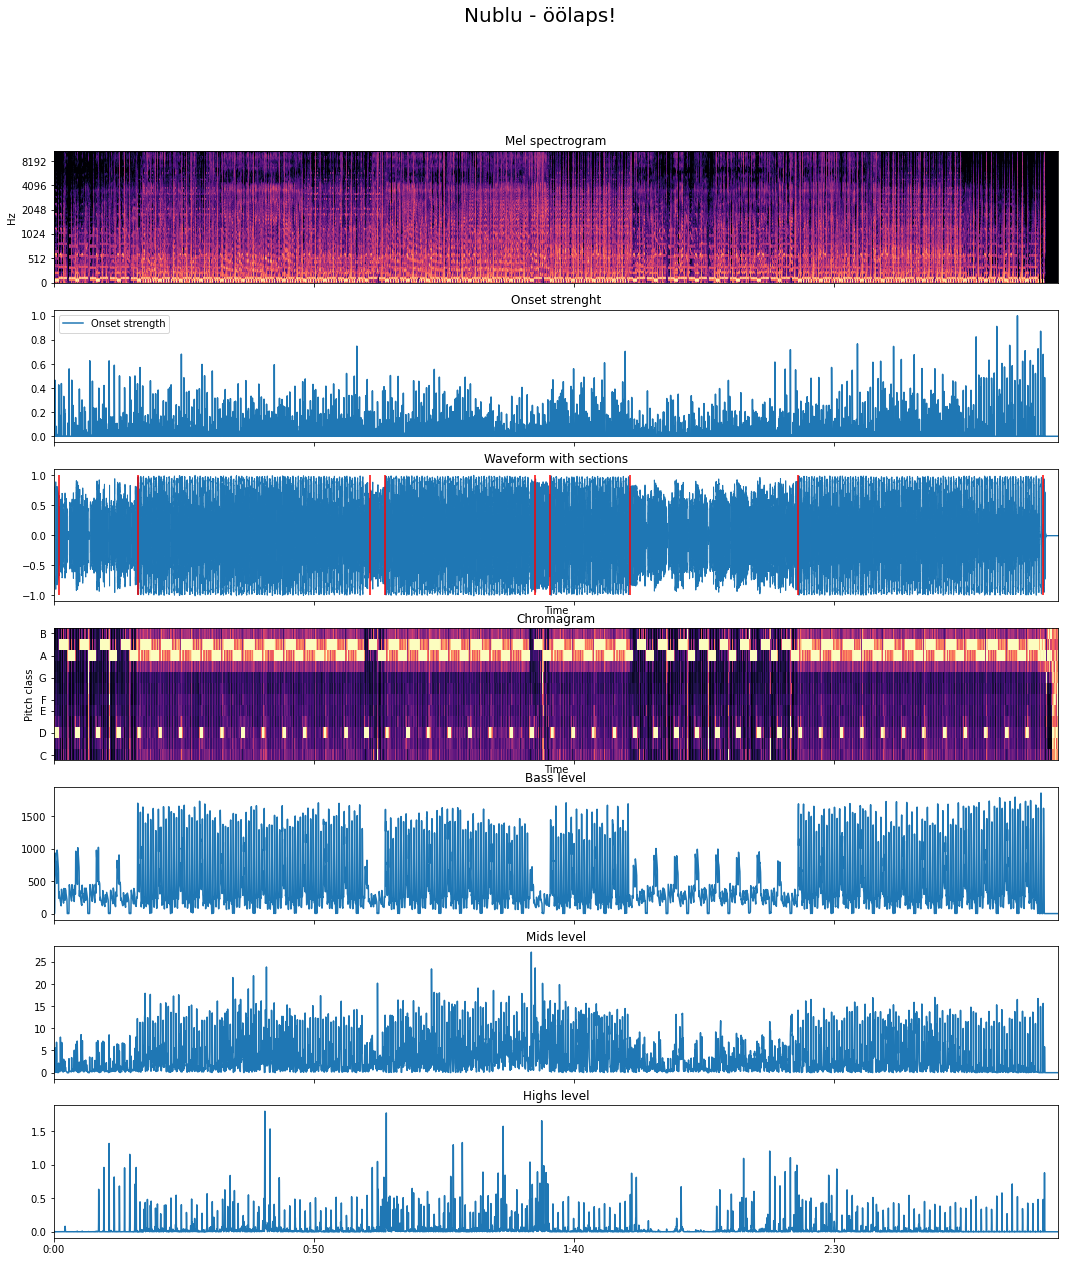

In [11]:
beat_grid = False
save_fig = False

fig, ax = plt.subplots(nrows=7, sharex=True)
fig.set_size_inches(18, 20)

librosa.display.specshow(librosa.power_to_db(M, ref=np.max), y_axis='mel', x_axis='time', hop_length=hop_length, ax=ax[0])
ax[0].label_outer()
ax[0].set(title='Mel spectrogram')

ax[1].plot(times, librosa.util.normalize(onset_env), label='Onset strength')
ax[1].legend()
ax[1].set(title='Onset strenght')

librosa.display.waveshow(y, sr=sr, ax=ax[2])
ax[2].vlines(times[bass_level_change], -1, 1, alpha=1, color='r', linestyle='solid', label='Beats')
ax[2].set(title='Waveform with sections')

librosa.display.specshow(chroma, x_axis='time', y_axis='chroma', hop_length=hop_length, ax=ax[3])
ax[3].set(title='Chromagram')

ax[4].plot(times, np.mean(M[low_eq[0]: low_eq[1]], axis=0), label='Bass')
ax[4].set(title='Bass level')

ax[5].plot(times, np.mean(M[mid_eq[0]: mid_eq[1]], axis=0), label='Mids')
ax[5].set(title='Mids level')

ax[6].plot(times, np.mean(M[high_eq[0]: high_eq[1]], axis=0), label='Highs')
ax[6].set(title='Highs level')

plt.suptitle(file_name.replace('.mp3', ''),fontsize=20)

if beat_grid:
    ax[0].vlines(times[beats], 0, 5000, alpha=0.5, color='w', linestyle='--', label='Beats')
    ax[1].vlines(times[beats], 0, 1, alpha=0.5, color='r', linestyle='--', label='Beats')
    ax[2].vlines(times[beats], -1, 1, alpha=0.5, color='r', linestyle='--', label='Beats')
    ax[4].vlines(times[beats], 0, 4000, alpha=0.5, color='r', linestyle='--', label='Beats')

if save_fig:
    plt.savefig(f"{file_name.replace('.mp3', '')}.png")